# Create all charts
---

## The data sets we used are:
* City of San Diego 311 service requests
* The San Diego zip codes from the US Census Bureau
* Economic census data for San Diego by zipcode from the US Census Bureau
* Open Weather Map History for temperature information

In [1]:
import os
import datetime
import numpy as np
import regex as reg
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
path_311 = os.path.join('..', 'data', '311_cleaned_data_.csv')
df = pd.read_csv(path_311)
df.dropna(inplace=True)
df.count()

service_request_id      29578
status_description      29578
mobile_web_status       29578
duplicate_verified      29578
override_duplicate      29578
functional_location     29578
source                  29578
closed_date             29578
updated_datetime        29578
open                    29578
closed                  29578
description             29578
agency_responsible      29578
service_name            29578
service_subtype         29578
lat                     29578
long                    29578
sap_problem_category    29578
sap_problem_type        29578
address                 29578
case_record_type        29578
district                29578
date                    29578
time                    29578
weekday                 29578
year                    29578
month                   29578
day                     29578
dtype: int64

In [3]:
final_path = os.path.join('..', 'data', 'final_311.csv')
final_df = pd.read_csv(final_path)
final_df.count()

zip_code                273337
Mean income             273337
MoE Mean income         273337
Median income           273337
MoE Median income       273337
total population        273337
service_request_id      273333
status_description      273333
mobile_web_status       273333
duplicate_verified      273333
override_duplicate      273333
functional_location     248264
source                  273332
closed_date             124629
updated_datetime        157712
open                    273333
closed                  273333
description             271997
agency_responsible      272778
service_name            272309
service_subtype          71812
lat                     273333
long                    273333
sap_problem_category    155658
sap_problem_type        155639
address                 272508
case_record_type        273333
district                272912
date                    273333
time                    273333
weekday                 273333
year                    273333
month   

### Number of 311 calls by month

* calls from 2017-03-11 to 2018-03-10

In [4]:
period_311 = df[df['date'] > '2017-03-10']
period_311 = period_311[period_311['date'] < '2018-03-11']
months = period_311.groupby('month', as_index=False)['service_request_id'].count()
months['month'] = months['month'].map(lambda x: datetime.date(1900, int(x), 1).strftime('%B'))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

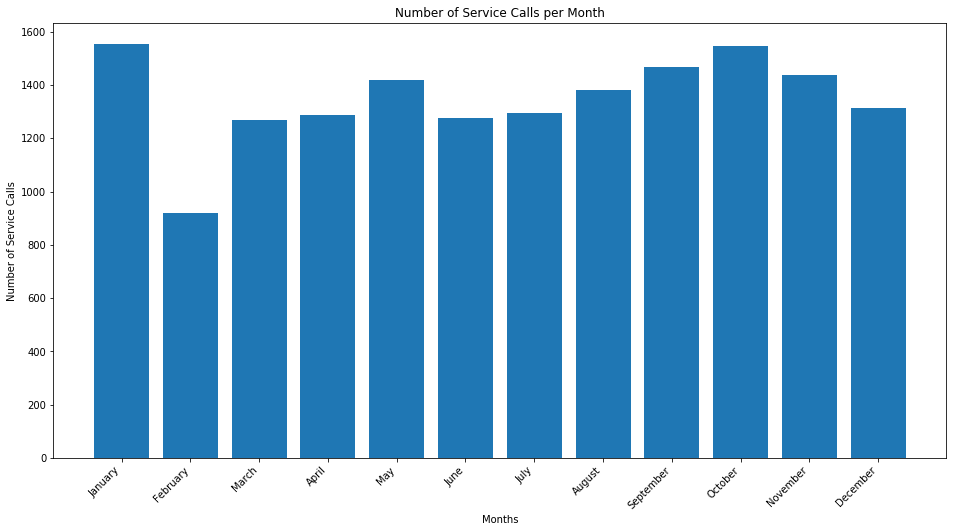

In [5]:
plt.figure(figsize=[16, 8])
plt.bar(months['month'], months['service_request_id'])
plt.title('Number of Service Calls per Month')
plt.xlabel('Months')
plt.ylabel('Number of Service Calls')
plt.xticks(rotation=45, ha='right')

### Number of 311 calls by type

* Garrett is working on this

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

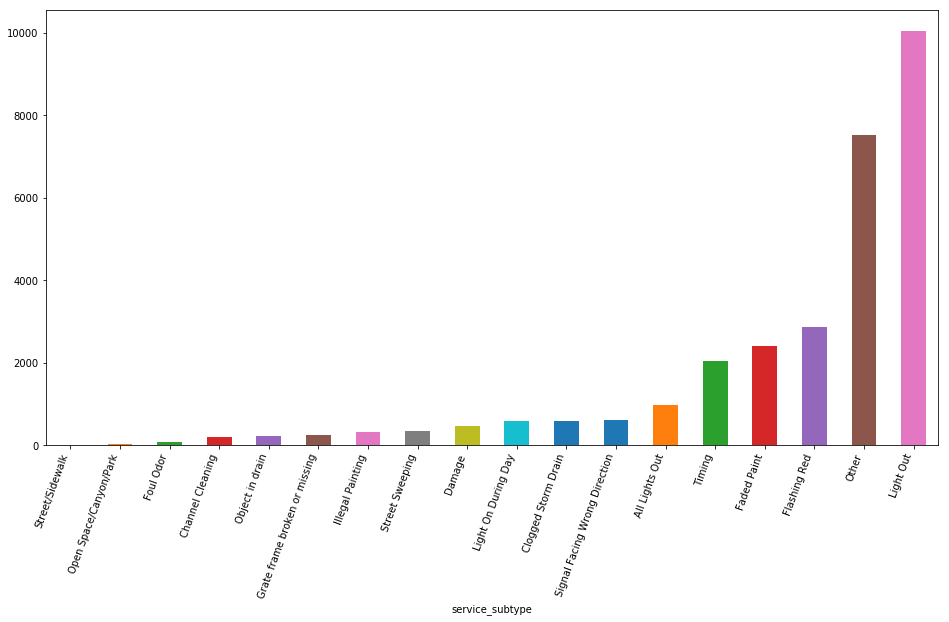

In [6]:
service = df.groupby('service_subtype')['service_request_id'].count().sort_values().tail(20)
fig, ax = plt.subplots(figsize=[16, 8])
service.plot.bar()
plt.xticks(rotation=70, ha='right')

### breakdown of percentage of call categories

### locations of callers (bubble plot?)

### Number of calls per capita by zipcode

In [7]:
pop_path = os.path.join('..', 'data', 'census_population_by_zip.csv')
pop_df = pd.read_csv(pop_path)
pop_df.tail()

,Unnamed: 0,zip_code,total population
45,45,92131,34425
46,46,92139,36720
47,47,92145,2096
48,48,92154,88016
49,49,92173,32416


### Number of calls by median household income of zip

In [8]:
income_path = os.path.join('..', 'data', 'census_income_by_zip.csv')
income_df = pd.read_csv(income_path)
income_df.head()

,zip_code,Mean income,MoE Mean income,Median income,MoE Median income
0,91911,62932,2137,51383,1874
1,91914,137640,8680,124578,7047
2,91915,111918,8589,104170,6753
3,91932,59870,2942,48010,1975
4,91942,70677,3837,55753,3194


In [9]:
pop_income_df = pop_df.merge(income_df, on='zip_code', how='right')
pop_income_df.head()

,Unnamed: 0,zip_code,total population,Mean income,MoE Mean income,Median income,MoE Median income
0,0,91911,84241,62932,2137,51383,1874
1,1,91914,16865,137640,8680,124578,7047
2,2,91915,30679,111918,8589,104170,6753
3,3,91932,26801,59870,2942,48010,1975
4,4,91942,39795,70677,3837,55753,3194


In [10]:
zip_gp = final_df.groupby('zip_code', as_index=False)
med_income = zip_gp['Median income'].mean()
zip_calls = zip_gp['service_request_id'].count()

In [11]:
calls_income = med_income.merge(zip_calls, on='zip_code', how='outer')
calls_income.head()

,zip_code,Median income,service_request_id
0,91911,51383,2170
1,91914,124578,1
2,91915,104170,0
3,91932,48010,3763
4,91942,55753,657


In [31]:
bins = [0, 35000, 55000, 75000, 95000, 115000, 999999999]
bin_names = ['<$35,000', '$35,001-$55,000', '$55,001-$75,000', '$75,001-$95,000', '$95,001-$115,000', '>$115,000']
calls_income['income_ranges'] = pd.cut(x=calls_income['Median income'], bins=bins, labels=bin_names)
calls_income_gp = calls_income.groupby(by='income_ranges', as_index=False)
call_count = calls_income_gp['service_request_id'].sum()
call_count

,income_ranges,service_request_id
0,"<$35,000",12340
1,"$35,001-$55,000",84868
2,"$55,001-$75,000",129601
3,"$75,001-$95,000",16892
4,"$95,001-$115,000",18114
5,">$115,000",11518


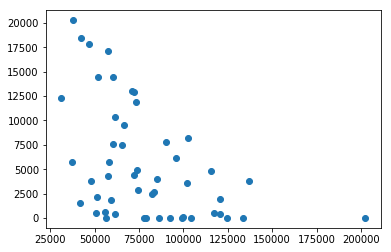

In [13]:
plt.scatter(med_income['Median income'], zip_calls['service_request_id'])

### Number of calls by crime rate of zip

### Percent of call types by median household income (stacked bar)

### Number of calls by Temperature scatter

* calls from 2017-03-11 to 2018-03-10

In [14]:
owm_path = os.path.join('..', 'data', 'owm_2016_2018.csv')
temp_df = pd.read_csv(owm_path)
temp_df['date'] = temp_df['dt_iso'].map(lambda x: reg.sub('\s\d{2}:\d{2}:\d{2}\s\+\d{4}\sUTC', '', x))
temp_df = temp_df[temp_df['date'] > '2017-03-10']
temp_df = temp_df[temp_df['date'] < '2018-03-11']
temp_df = temp_df.groupby('date', as_index=False).mean()

In [15]:
date_311 = period_311.groupby('date', as_index=False).count()

Text(0,0.5,'Temperature in Fahrenheit')

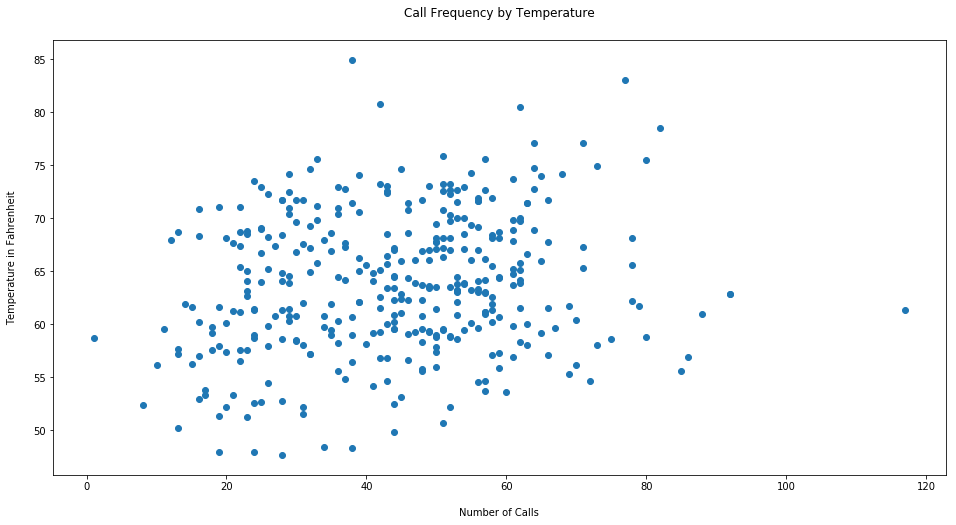

In [26]:
plt.figure(figsize=[16, 8])
plt.scatter(date_311['service_request_id'], temp_df['temp_f'])
plt.title('Call Frequency by Temperature', pad=23)
plt.xlabel('Number of Calls', labelpad=16)
plt.ylabel('Temperature in Fahrenheit', labelpad=16)

### Number fo calls by weekday

In [17]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', ]
weekdays = df.groupby('weekday', as_index=False)['service_request_id'].count()
weekdays['day_order'] = weekdays['weekday'].map(lambda x: days.index(x))
weekdays.sort_values('day_order', inplace=True)
weekdays

,weekday,service_request_id,day_order
1,Monday,4871,0
5,Tuesday,5140,1
6,Wednesday,5070,2
4,Thursday,4801,3
0,Friday,4631,4
2,Saturday,2688,5
3,Sunday,2377,6


Text(0,0.5,'Number of Calls')

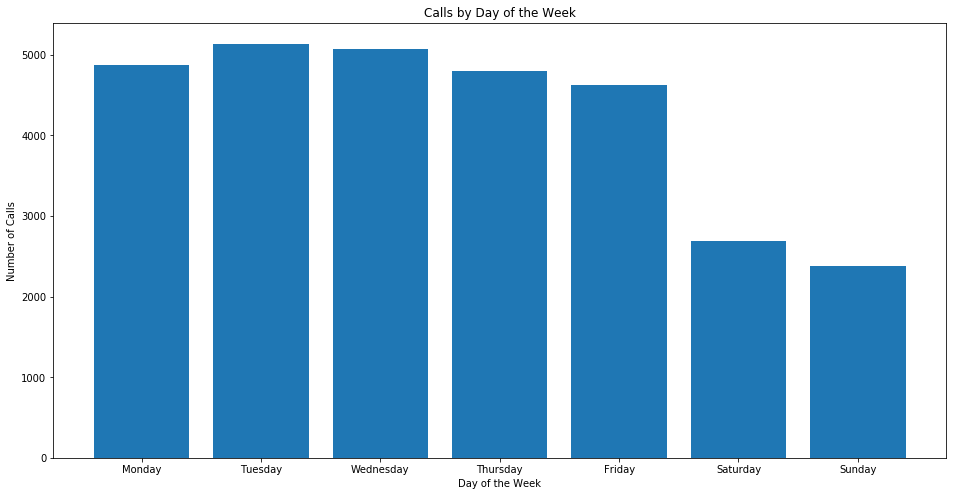

In [18]:
plt.figure(figsize=[16, 8])
plt.bar(weekdays['weekday'], weekdays['service_request_id'])
plt.title('Calls by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Calls')